# Interpolation visualization

This documents shows effects of different approaches to the signal interpolation

In [1]:
from functools import partial
from multiprocessing import cpu_count
from multiprocessing.pool import Pool

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from distance_determination import estimate_dist, get_current_freq
from interpolation.interpolate import interpolate, sklearn_interpolations
from interpolation.metrics import get_RMSE
from interpolation.wsinterp import wsinterp
from simul.utilities.data import load_experiment
from simul.vis.dist_probs import vis_dist_probs
from simul.vis.signals import get_vis_df, vis_signals, vis_signals2d
from tqdm.auto import tqdm, trange

%load_ext autoreload
%autoreload 2

In [2]:
from distance_determination import estimate_dist, simulate_signals
from run_experiment import experiments

exp_name = "default_full"
params = experiments[exp_name]
dist, signals_data = simulate_signals(params)

exp_name = "default"
params = experiments[exp_name]
dist, signals_data_pruned = simulate_signals(params)

Simulating distances and signals:   0%|          | 0/23336 [00:00<?, ?it/s]

Simulating distances and signals:   0%|          | 0/23336 [00:00<?, ?it/s]

Generate the data using different interpolations

In [3]:
interpolation_kinds = sklearn_interpolations + ["Whittaker–Shannon"]
interp_signals = [
    (interpolate(signals_data_pruned, kind), kind) for kind in interpolation_kinds
]

  0%|          | 0/40 [00:00<?, ?it/s]

The figure below shows the original signal, as well as different approaches to the interpolation. On the right you can toggle on or off the signals to have a better view.

In [4]:
df = get_vis_df(
    params.tss,
    signals_data,
    signals_data_pruned,
    *interp_signals,
    n=200,
    freqs=[0],
)

In [5]:
vis_signals(df)

The above graph looks fancy, but a little bit messy. Take a look at the same graph in 2d.

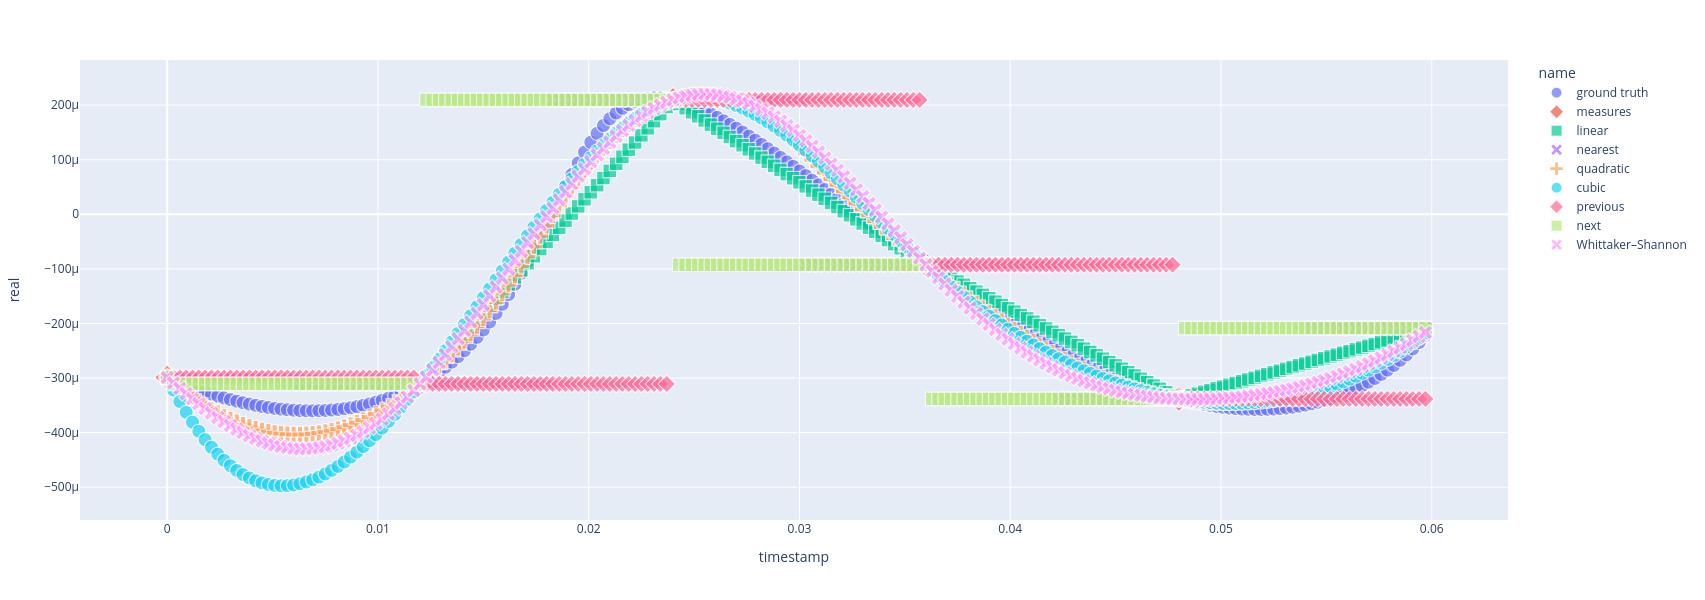

In [6]:
vis_signals2d(df)

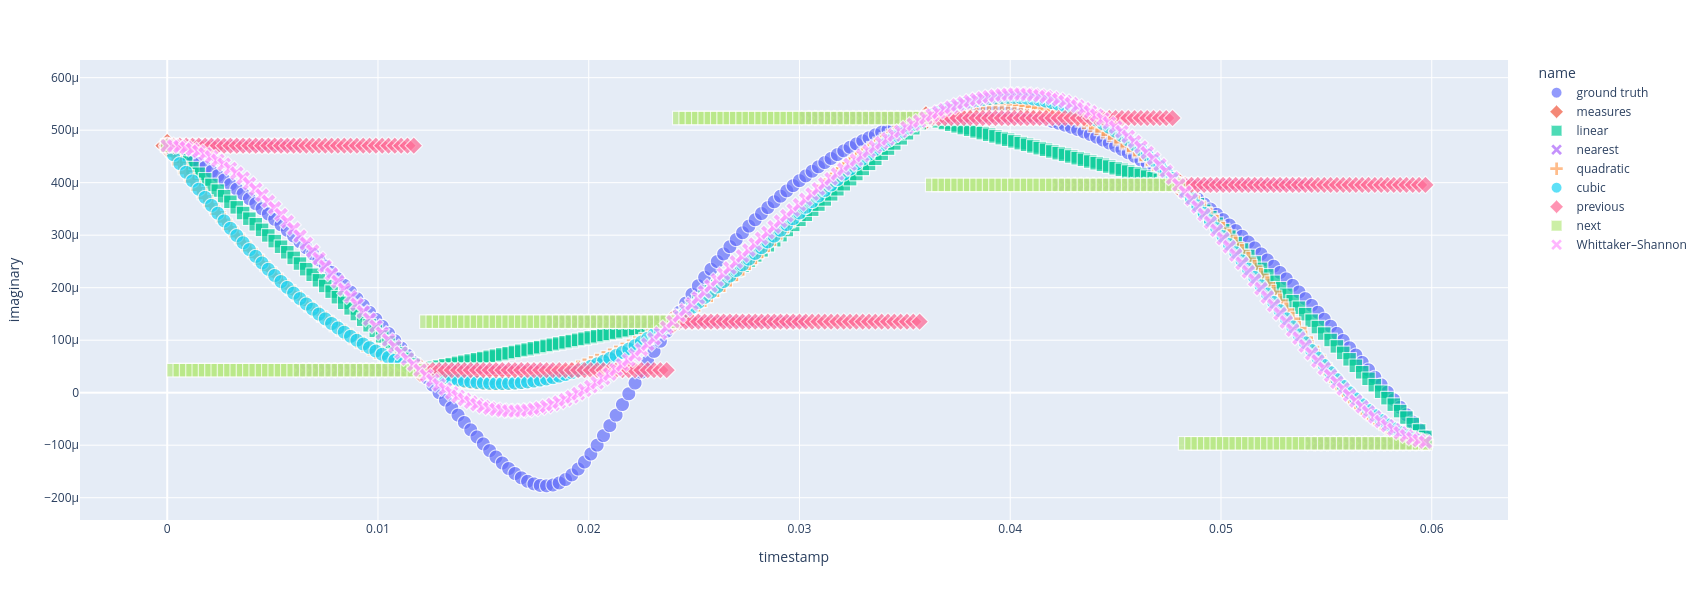

In [7]:
vis_signals2d(df, "imaginary")

Here will be an FFT comparison for different interpolations

Below the table with RMSEs for absolute value errors presented for different interpolations.

In [8]:
df = get_vis_df(params.tss, signals_data, signals_data_pruned, *interp_signals)

In [9]:
rmse = get_RMSE(df)
rmse

  0%|          | 0/40 [00:00<?, ?it/s]

name  Whittaker–Shannon     cubic    linear   nearest      next  previous  \
RMSE           0.007374  0.004195  0.011731  0.022209  0.041332  0.040989   

name  quadratic  
RMSE   0.004816

The units are the same as are in the signal data

In [10]:
f = partial(estimate_dist, params=params)

gt_dist_probs = f(signals_data)

with Pool(cpu_count()) as pool:
    args = [d[0] for d in interp_signals]
    dist_probss = pool.map(f, args)

Interpolating NaNs:   0%|          | 0/40 [00:00<?, ?it/s]

Searching for distances:   0%|          | 0/2917 [00:00<?, ?it/s]

In [11]:
diffs = [dist_probs - gt_dist_probs for dist_probs in dist_probss]

dist_rmse = [
    np.sqrt(((np.real(diff) ** 2 + np.imag(diff) ** 2) ** 2).mean()) for diff in diffs
]

pd.DataFrame(
    data=dist_rmse, index=[name for signal, name in interp_signals], columns=["RMSE"]
).T

linear   nearest  quadratic     cubic  previous      next  \
RMSE  0.01563  0.018498    0.00975  0.009659  0.019834  0.020572   

      Whittaker–Shannon  
RMSE           0.005389